In [1]:
#pip install numpy 

In [2]:
#pip install scikit-learn

In [3]:
#pip install matplotlib

In [4]:
#pip install seaborn 

In [5]:
#pip install statsmodels

In [6]:
#pip install xgboost

In [7]:
#pip install mlflow


# Bibliotheken laden

In [8]:
# Bibliotheken importieren

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, TimeSeriesSplit, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler

import xgboost as xgb
from xgboost import XGBRegressor

import mlflow
import mlflow.xgboost
import os

#from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV # new import we need for this week

# Daten laden

In [9]:
# Daten laden
df_train_ML_ready = pd.read_parquet("/Users/laurapeters/Desktop/VS-Time-series-Projekt/files/df_train_ML_ready.parquet")
df_train_ML_ready.head()

,date,id,store_nbr,item_nbr,unit_sales,onpromotion,is_outlier,year,month,day,...,holiday_transferred,transactions,lag_7,lag_30,lag_364,rolling_7d_std,rolling_30d_std,rolling_7d_mean,rolling_30d_mean,is_weekend
0,2014-02-21,19281571,24,103520,2.0,False,False,2014,2,21,...,0,2455.0,10.0,3.0,6.0,6.658328,9.693522,9.000000,11.633333,0
1,2014-02-22,19331514,24,103520,8.0,False,False,2014,2,22,...,0,2291.0,10.0,3.0,16.0,2.751623,2.725992,5.714286,6.500000,1
2,2014-02-23,19382503,24,103520,3.0,False,False,2014,2,23,...,0,1419.0,8.0,4.0,7.0,18.442962,14.250791,22.142857,23.133333,1
3,2014-02-24,19432532,24,103520,1.0,False,False,2014,2,24,...,0,2247.0,4.0,5.0,1.0,3.716117,2.725782,4.857143,4.466667,0
4,2014-02-25,19481433,24,103520,6.0,False,False,2014,2,25,...,0,2192.0,2.0,4.0,2.0,11.338934,11.418074,31.714286,32.800000,0


In [10]:
df_train_ML_ready.columns

Index(['date', 'id', 'store_nbr', 'item_nbr', 'unit_sales', 'onpromotion',
       'is_outlier', 'year', 'month', 'day', 'day_of_week', 'family',
       'item_class', 'perishable', 'dcoilwtico', 'city', 'state', 'store_type',
       'sim_store_cluster', 'holiday_type', 'holiday_locale',
       'holiday_locale_name', 'holiday_description', 'holiday_transferred',
       'transactions', 'lag_7', 'lag_30', 'lag_364', 'rolling_7d_std',
       'rolling_30d_std', 'rolling_7d_mean', 'rolling_30d_mean', 'is_weekend'],
      dtype='object')

In [11]:
# Speicherort für MLflow Runs (lokal auf deinem Mac)
mlflow_storage_path = "/Users/laurapeters/Desktop/VS-Time-series-Projekt/mlflow_results"
os.makedirs(mlflow_storage_path, exist_ok=True)

# Tracking konfigurieren
mlflow.set_tracking_uri(f"file:{mlflow_storage_path}")

# Experiment festlegen (wird automatisch erstellt, falls nicht vorhanden)
mlflow.set_experiment("Modell-Vergleiche")

<Experiment: artifact_location='file:///Users/laurapeters/Desktop/VS-Time-series-Projekt/mlflow_results/551520531669055046', creation_time=1756999473550, experiment_id='551520531669055046', last_update_time=1756999473550, lifecycle_stage='active', name='Modell-Vergleiche', tags={}>

## Featurebeschreibung

- Zeitfeatures (year, month, day, day_of_week, is_weekend) → wichtig um Saisonalität und Wochentageffekte einzufangen.
- Item-Metadaten (family, item_class) → item_class und family haben hohe Kardinalität → evtl. Target-Encoding statt One-Hot.
- Store-Metadaten (city, state, store_type, sim_store_cluster) → nützlich, aber city/state erzeugen viele Dummies → evtl. Clustering oder Target-Encoding.
- Promotions (onpromotion) → sehr starkes Signal.
Ökonomische Daten (dcoilwtico) → schwaches, aber vorhandenes Signal.
- Holiday Features → reicht is_holiday oder holiday_type.
- Lag Features (lag_7, lag_30, lag_364)
- Rolling Features (rolling_mean_7d, rolling_std_7d, rolling_mean_30d, rolling_std_30d, rolling_std_7d_lagged) → gut, wichtig für kurzfristige Dynamik.
- Transactions → hilfreich, aber nur bei Läden mit Transaktionsdaten.

# Target // Features definieren

In [12]:
max_date = '2014-04-01'
df_train_ML_ready = df_train_ML_ready[(df_train_ML_ready['date'] < max_date)]

split_date = '2014-01-01'
train = df_train_ML_ready[df_train_ML_ready['date'] < split_date]
test = df_train_ML_ready[df_train_ML_ready['date'] > split_date]


In [13]:
# Define target variable (unit_sales) and features
X = df_train_ML_ready[['onpromotion',
       'is_outlier', 'year', 'month', 'day', 'day_of_week', 'family',
       'item_class', 'dcoilwtico', 'city', 'state', 'store_type',
       'sim_store_cluster', 'holiday_type', 'holiday_transferred',
       'transactions', 'lag_7', 'lag_30', 'lag_364',
       'rolling_7d_std', 'rolling_30d_std', 'rolling_7d_mean',
       'rolling_30d_mean', 'is_weekend']]
y = df_train_ML_ready['unit_sales']



In [14]:
X

,onpromotion,is_outlier,year,month,day,day_of_week,family,item_class,dcoilwtico,city,...,holiday_transferred,transactions,lag_7,lag_30,lag_364,rolling_7d_std,rolling_30d_std,rolling_7d_mean,rolling_30d_mean,is_weekend
0,False,False,2014,2,21,4,GROCERY I,1028,102.53,Guayaquil,...,0,2455.0,10.0,3.0,6.0,6.658328,9.693522,9.000000,11.633333,0
1,False,False,2014,2,22,5,GROCERY I,1028,50.82,Guayaquil,...,0,2291.0,10.0,3.0,16.0,2.751623,2.725992,5.714286,6.500000,1
2,False,False,2014,2,23,6,GROCERY I,1028,50.82,Guayaquil,...,0,1419.0,8.0,4.0,7.0,18.442962,14.250791,22.142857,23.133333,1
3,False,False,2014,2,24,0,GROCERY I,1028,103.17,Guayaquil,...,0,2247.0,4.0,5.0,1.0,3.716117,2.725782,4.857143,4.466667,0
4,False,False,2014,2,25,1,GROCERY I,1028,102.20,Guayaquil,...,0,2192.0,2.0,4.0,2.0,11.338934,11.418074,31.714286,32.800000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3671971,False,False,2014,3,27,3,GROCERY I,1040,101.25,Guayaquil,...,0,1472.0,6.0,11.0,7.0,5.159365,2.677278,3.571429,2.733333,0
3671972,False,False,2014,3,28,4,GROCERY I,1040,101.73,Guayaquil,...,0,1709.0,8.0,6.0,6.0,55.485305,59.213427,82.428571,75.666667,0
3671973,False,False,2014,3,29,5,GROCERY I,1040,50.82,Guayaquil,...,0,1790.0,4.0,3.0,1.0,1.290994,23.849360,3.000000,11.966667,1
3671974,False,False,2014,3,30,6,GROCERY I,1040,50.82,Guayaquil,...,0,1684.0,11.0,6.0,6.0,5.618846,7.789176,21.285714,19.133333,1


# Train Test Split

In [15]:
# Split the data into training and testing sets (80% training, 20% testing)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

print("Train:", X_train.shape, y_train.shape)
print("Test:",  X_test.shape, y_test.shape)


Train: (121604, 24) (121604,)
Test: (30401, 24) (30401,)


# Encoding

In [16]:
df_train_ML_ready.columns

Index(['date', 'id', 'store_nbr', 'item_nbr', 'unit_sales', 'onpromotion',
       'is_outlier', 'year', 'month', 'day', 'day_of_week', 'family',
       'item_class', 'perishable', 'dcoilwtico', 'city', 'state', 'store_type',
       'sim_store_cluster', 'holiday_type', 'holiday_locale',
       'holiday_locale_name', 'holiday_description', 'holiday_transferred',
       'transactions', 'lag_7', 'lag_30', 'lag_364', 'rolling_7d_std',
       'rolling_30d_std', 'rolling_7d_mean', 'rolling_30d_mean', 'is_weekend'],
      dtype='object')

one hot encoding  
    'city', 'state', 'store_type',
       'sim_store_cluster', 'holiday_type', 'holiday_transferred',
       , 'family',
       '

min/max 
    'dcoilwtico','transactions',  'lag_7', 'lag_30', 'lag_364', 'rolling_std_7d',
       'rolling_mean_7d', 'rolling_std_30d', 'rolling_mean_30d',
       'rolling_std_7d','unit_sales'
       
so lassen
    'store_nbr', 'item_nbr', 'item_class', 'year', 'month', 'day', 'day_of_week', 'onpromotion', 'is_outlier', 'is_weekend'

## One Hot Encoding

In [17]:
# Kategoriale Spalten
X_cat = ['city', 'state', 'store_type', 'sim_store_cluster', 
         'holiday_type', 'holiday_transferred', 'family']

for col in X_cat:
    X_train[col] = X_train[col].astype(str)
    X_test[col] = X_test[col].astype(str)
    
# Encoder initialisieren
ohe = OneHotEncoder(drop='first', sparse_output=False, handle_unknown='ignore')

# Fit + Transform auf Trainingsdaten
X_train_ohe = pd.DataFrame(
    ohe.fit_transform(X_train[X_cat]),
    columns=ohe.get_feature_names_out(X_cat),
    index=X_train.index
)

# Alte Spalten entfernen und OHE-Spalten anhängen
X_train_prepared = pd.concat([X_train.drop(columns=X_cat), X_train_ohe], axis=1)


In [18]:
X_test_ohe = pd.DataFrame(
    ohe.transform(X_test[X_cat]),  # Achtung: transform, nicht fit_transform
    columns=ohe.get_feature_names_out(X_cat),
    index=X_test.index
)

X_test_prepared = pd.concat([X_test.drop(columns=X_cat), X_test_ohe], axis=1)


## Min/Max-Scaler 

In [19]:
X_num = ['dcoilwtico','transactions',  'lag_7', 'lag_30', 'lag_364', 'rolling_7d_std',
         'rolling_30d_std', 'rolling_7d_mean', 'rolling_30d_mean']

scaler = MinMaxScaler()

X_train_prepared[X_num] = scaler.fit_transform(X_train[X_num])

In [20]:
X_test_prepared[X_num] = scaler.transform(X_test[X_num])


In [21]:
'''
# Training
y_train_log = np.log1p(y_train)  # log(1 + y)
final_model.fit(X_train, y_train_log)

# Vorhersage
y_pred_log = final_model.predict(X_test)
y_pred = np.expm1(y_pred_log)  # Rücktransformation
'''

'\n# Training\ny_train_log = np.log1p(y_train)  # log(1 + y)\nfinal_model.fit(X_train, y_train_log)\n\n# Vorhersage\ny_pred_log = final_model.predict(X_test)\ny_pred = np.expm1(y_pred_log)  # Rücktransformation\n'

# y log-Transformieren

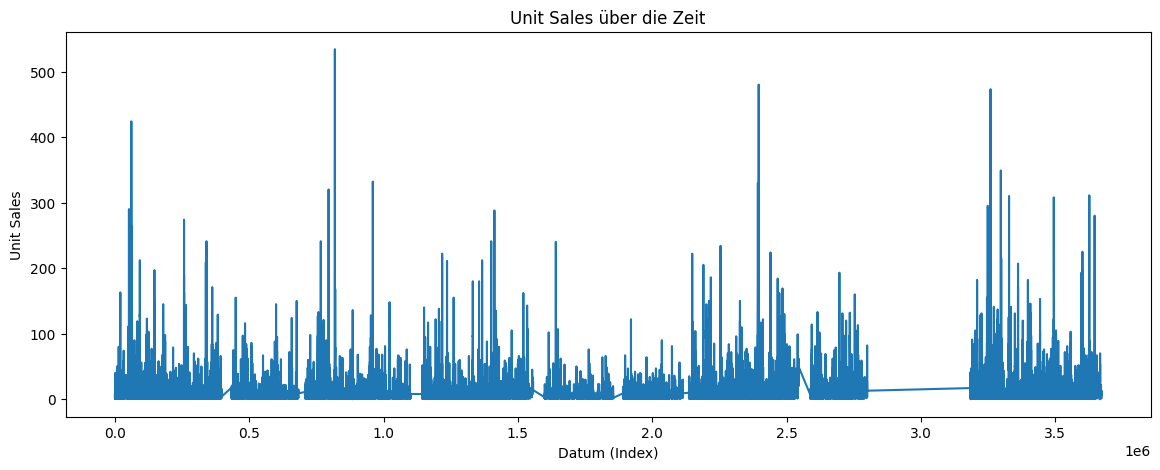

In [22]:
plt.figure(figsize=(14,5))
plt.plot(df_train_ML_ready.index, df_train_ML_ready['unit_sales'])
plt.title('Unit Sales über die Zeit')
plt.xlabel('Datum (Index)')
plt.ylabel('Unit Sales')
plt.show()

In [23]:
y_train_log = np.log1p(y_train)
y_test_log = np.log1p(y_test)

In [24]:
y_test_log.isnull().sum()

0

## DF prüfen

In [25]:
bool_cols = X_train_prepared.select_dtypes(include='bool').columns
X_train_prepared[bool_cols] = X_train_prepared[bool_cols].astype(int)
X_test_prepared[bool_cols] = X_test_prepared[bool_cols].astype(int)

In [26]:
X_train_prepared.columns

Index(['onpromotion', 'is_outlier', 'year', 'month', 'day', 'day_of_week',
       'item_class', 'dcoilwtico', 'transactions', 'lag_7', 'lag_30',
       'lag_364', 'rolling_7d_std', 'rolling_30d_std', 'rolling_7d_mean',
       'rolling_30d_mean', 'is_weekend', 'city_Guayaquil', 'city_Playas',
       'store_type_B', 'store_type_C', 'store_type_D', 'store_type_E',
       'sim_store_cluster_10', 'sim_store_cluster_17', 'sim_store_cluster_3',
       'sim_store_cluster_6', 'holiday_type_Additional',
       'holiday_type_Holiday', 'holiday_transferred_False', 'family_CLEANING',
       'family_GROCERY I'],
      dtype='object')

In [27]:
print(X_train_prepared.select_dtypes(include='object').dtypes)


Series([], dtype: object)


# XGBoost

In [28]:
# Initialize the XGBoost regressor
xgboost_model = XGBRegressor(objective='reg:squarederror', random_state=42) # enable_categorical=True

# Train the XGBoost model auf log-transformiertem y
xgboost_model.fit(X_train_prepared, y_train_log)

# Make predictions im log-Space
y_pred_log = xgboost_model.predict(X_test_prepared)

# Rücktransformation in Original-Skala
y_pred = np.expm1(y_pred_log)


## MLFLOW

In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np
import joblib
import mlflow
import mlflow.xgboost
from sklearn.metrics import mean_absolute_error, mean_squared_error

# -----------------------------------
# Unterordner für Plots erstellen
# -----------------------------------
os.makedirs("plots", exist_ok=True)

# Zusatzmetriken definieren
def smape(y_true, y_pred):
    return 100 * np.mean(
        2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred) + 1e-8)
    )

def wmape(y_true, y_pred):
    return 100 * np.sum(np.abs(y_true - y_pred)) / np.sum(np.abs(y_true))

# MLflow Backend & Experiment
mlflow.set_tracking_uri("file:/Users/laurapeters/Desktop/VS-Time-series-Projekt/mlflow_results")
mlflow.set_experiment("XGB_Forecast_Experiment")

# Optional: Code-Datei sichern
script_path = "mlflow_logging_xgb.py"  # Name dieses Skripts

# -----------------------------------
# MLflow Run starten
# -----------------------------------
with mlflow.start_run(run_name="XGB_run_1"):

    # -------------------------------
    # Training & Vorhersage
    # -------------------------------
    xgboost_model.fit(X_train_prepared, y_train_log)
    y_pred_log = xgboost_model.predict(X_test_prepared)
    y_pred = np.expm1(y_pred_log)

    # -------------------------------
    # Metriken berechnen
    # -------------------------------
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    smape_val = smape(y_test, y_pred)
    wmape_val = wmape(y_test, y_pred)

    # -------------------------------
    # Parameter & Metriken loggen
    # -------------------------------
    mlflow.log_param("model_type", "XGBRegressor")
    mlflow.log_params(xgboost_model.get_params())
    mlflow.log_metric("MAE", mae)
    mlflow.log_metric("MSE", mse)
    mlflow.log_metric("RMSE", rmse)
    mlflow.log_metric("SMAPE", smape_val)
    mlflow.log_metric("wMAPE", wmape_val)

    # -------------------------------
    # Plot erstellen, speichern & loggen
    # -------------------------------
    plt.figure(figsize=(14, 7))
    plt.plot(y_test.index, y_test.values, label='Actual Sales')
    plt.plot(y_test.index, y_pred, label='Predicted Sales', color='red')
    plt.title('Actual vs Predicted Sales using XGBoost')
    plt.legend()
    plt.tight_layout()

    plot_file = os.path.join("plots", "forecast_actual_vs_predicted.png")
    plt.savefig(plot_file)
    plt.close()
    mlflow.log_artifact(plot_file)

    # -------------------------------
    # Modell loggen
    # -------------------------------
    mlflow.xgboost.log_model(xgboost_model, artifact_path="model")

    # -------------------------------
    # Optional: gesamten Code als Artefakt loggen
    # -------------------------------
    if os.path.exists(script_path):
        mlflow.log_artifact(script_path)

print(
    f"Run beendet – MAE={mae:.2f}, RMSE={rmse:.2f}, "
    f"SMAPE={smape_val:.2f}%, wMAPE={wmape_val:.2f}%"
)


2025/09/04 17:26:07 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py:1028: UserWarning: [17:26:07] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  self.get_booster().save_model(fname)
2025/09/04 17:26:09 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


Run beendet – MAE=6.82, RMSE=14.63, SMAPE=48.15%, wMAPE=41.95%


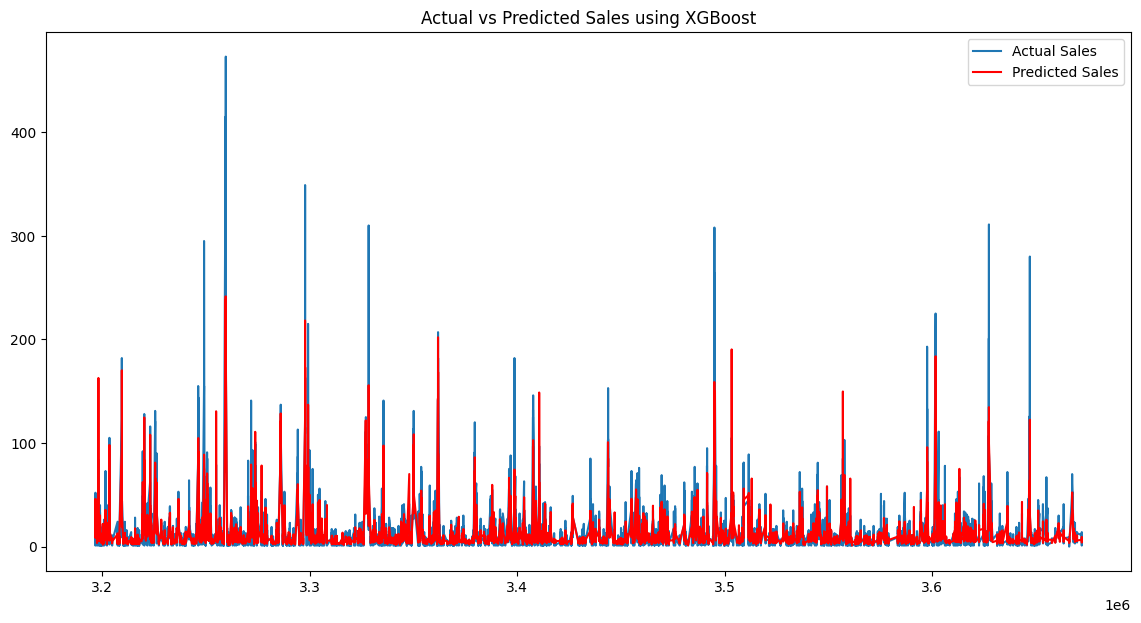

In [30]:
# Plot the actual vs predicted values
plt.figure(figsize=(14, 7))
plt.plot(y_test.index, y_test.values, label='Actual Sales')
plt.plot(y_test.index, y_pred, label='Predicted Sales', color='red')
plt.title('Actual vs Predicted Sales using XGBoost')
plt.legend()
plt.show()

In [31]:
# y_test and y_pred are Pandas Series aligned by date
mae  = mean_absolute_error(y_test, y_pred)

print(f"MAE   : {mae:.3f} units")

MAE   : 6.822 units


In [32]:
'''Unterschiede
MAE = absoluter Fehler → leicht interpretierbar (z. B. „im Schnitt um 5 Einheiten daneben“).
RMSE = stärker von Ausreißern beeinflusst.
SMAPE = symmetrische prozentuale Abweichung, skaliert zwischen 0–200 %.
wMAPE = gewichtete prozentuale Abweichung, gewichtet nach dem Umsatzvolumen → oft in Forecasting-Wettbewerben verwendet.
'''

# MAE & RMSE
mae = mean_absolute_error(y_test, y_pred)
#rmse = mean_squared_error(y_test, y_pred)
#rmse = mean_squared_error(y_test, y_pred, squared=False)
rmse = np.sqrt(np.mean((y_test - y_pred)**2))



# SMAPE
def smape(y_true, y_pred):
    return 100 * np.mean(
        2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred) + 1e-8)
    )

# wMAPE
def wmape(y_true, y_pred):
    return 100 * np.sum(np.abs(y_true - y_pred)) / np.sum(np.abs(y_true))

smape_val = smape(y_test, y_pred)
wmape_val = wmape(y_test, y_pred)

# Ausgabe
print("MAE = absoluter Fehler → leicht interpretierbar (z. B. „im Schnitt um 5 Einheiten daneben“).")
print(f"MAE   : {mae:.3f} units")
print("RMSE = stärker von Ausreißern beeinflusst.")
print(f"RMSE  : {rmse:.3f} units")
print("SMAPE = symmetrische prozentuale Abweichung, skaliert zwischen 0–200 %.")
print(f"SMAPE : {smape_val:.2f} %")
print("wMAPE = gewichtete prozentuale Abweichung, gewichtet nach dem Umsatzvolumen → oft in Forecasting-Wettbewerben verwendet.")
print(f"wMAPE : {wmape_val:.2f} %")


MAE = absoluter Fehler → leicht interpretierbar (z. B. „im Schnitt um 5 Einheiten daneben“).
MAE   : 6.822 units
RMSE = stärker von Ausreißern beeinflusst.
RMSE  : 14.625 units
SMAPE = symmetrische prozentuale Abweichung, skaliert zwischen 0–200 %.
SMAPE : 48.15 %
wMAPE = gewichtete prozentuale Abweichung, gewichtet nach dem Umsatzvolumen → oft in Forecasting-Wettbewerben verwendet.
wMAPE : 41.95 %


# Hyperparametertuning

In [33]:
#df_train_clean.head()

In [34]:
#X_train.dtypes

In [35]:
# Initializing the model
#xgb = XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1)

# Define the parameter grid, trying 3 values for each parameter
param_grid = {
    'eta': [0.01, 0.1, 0.3],
    'max_depth': [3, 5, 7],
    'subsample': [0.6, 0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0],
    'n_estimators': [100, 200, 300, 500]
}

# Time series split for cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Randomized search with cross-validation
random_search = RandomizedSearchCV(estimator=xgboost_model,
																	 param_distributions=param_grid, 
                                   cv=tscv,
                                   n_iter=10,
                                   scoring='neg_mean_squared_error')

# Fit the model and search for the best hyperparameters
random_search.fit(X_train_prepared, y_train_log)

# Get best hyperparameters
best_params_rs = random_search.best_params_
print("Best Parameters for XGBoost:", best_params_rs)

#läuft 30 bis 60 Minuten
# Best Parameters for XGBoost: {'subsample': 0.7, 'n_estimators': 200, 'max_depth': 3, 'eta': 0.3, 'colsample_bytree': 0.7}


Best Parameters for XGBoost: {'subsample': 0.7, 'n_estimators': 200, 'max_depth': 5, 'eta': 0.1, 'colsample_bytree': 0.8}


## MLFLOW

In [36]:
# Unterordner für Plots erstellen
os.makedirs("plots", exist_ok=True)

# Zusatzmetriken definieren
def smape(y_true, y_pred):
    return 100 * np.mean(
        2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred) + 1e-8)
    )

def wmape(y_true, y_pred):
    return 100 * np.sum(np.abs(y_true - y_pred)) / np.sum(np.abs(y_true))

# MLflow Run starten
with mlflow.start_run(run_name="XGB_RandomSearch"):

    # Hyperparameter loggen (RandomSearch-Ergebnis)
    mlflow.log_params(best_params_rs)
    mlflow.log_param("model_type", "XGBRegressor_RandomSearch")

    # Finales Modell mit besten Parametern definieren
    final_model_rs = XGBRegressor(
        objective='reg:squarederror',
        n_estimators=best_params_rs["n_estimators"],
        max_depth=best_params_rs["max_depth"],
        learning_rate=best_params_rs["eta"],
        subsample=best_params_rs["subsample"],
        colsample_bytree=best_params_rs["colsample_bytree"],
        random_state=42
    )

    # Trainieren auf den vorbereiteten Trainingsdaten (log-transformiertes y)
    final_model_rs.fit(X_train_prepared, y_train_log)

    # Vorhersage auf Testdaten
    y_pred_log = final_model_rs.predict(X_test_prepared)
    y_pred = np.expm1(y_pred_log)  # Rücktransformation

    # Metriken berechnen
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    smape_val = smape(y_test, y_pred)
    wmape_val = wmape(y_test, y_pred)

    # Metriken loggen
    mlflow.log_metric("MAE", mae)
    mlflow.log_metric("MSE", mse)
    mlflow.log_metric("RMSE", rmse)
    mlflow.log_metric("SMAPE", smape_val)
    mlflow.log_metric("wMAPE", wmape_val)

    # Plot erstellen
    plt.figure(figsize=(14, 7))
    plt.plot(y_test.index, y_test.values, label="Actual")
    plt.plot(y_test.index, y_pred, label="Predicted", color="red")
    plt.title("Actual vs Predicted Sales – RandomSearch XGBoost")
    plt.legend()
    plt.tight_layout()

    # Plot speichern & loggen
    plot_file = os.path.join("plots", "forecast_XGB_RandomSearch.png")
    plt.savefig(plot_file)
    plt.close()
    mlflow.log_artifact(plot_file)

    # Modell speichern
    mlflow.xgboost.log_model(final_model_rs, artifact_path="model")

print(f"RandomSearch Run abgeschlossen – "
      f"MAE={mae:.2f}, RMSE={rmse:.2f}, SMAPE={smape_val:.2f}%, wMAPE={wmape_val:.2f}%")


2025/09/04 17:27:00 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py:1028: UserWarning: [17:27:00] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  self.get_booster().save_model(fname)
2025/09/04 17:27:04 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


RandomSearch Run abgeschlossen – MAE=6.66, RMSE=14.28, SMAPE=47.35%, wMAPE=40.98%


In [37]:
# Train your final XGBoost model using the best parameters you found, and evaluate its performance on the test set

# Define final model with best parameters
final_model_rs = XGBRegressor(
    objective='reg:squarederror',  # or use 'reg:linear' if you're on older versions
    enable_categorical=True,
    n_estimators=best_params_rs["n_estimators"],
    max_depth=best_params_rs["max_depth"],
    learning_rate=best_params_rs["eta"],
    subsample=best_params_rs["subsample"],
    colsample_bytree=best_params_rs["colsample_bytree"],
    random_state=42
)

In [38]:
# Train the model
final_model_rs.fit(X_train_prepared, y_train_log)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8
,device,None
,early_stopping_rounds,None
,enable_categorical,True
,eval_metric,None


In [39]:
def forecast_metrics(y_true, y_pred):
    """
    Berechnet gängige Metriken für die Prognosegenauigkeit.

    Args:
        y_true (array-like): Die tatsächlichen Werte.
        y_pred (array-like): Die vorhergesagten Werte.

    Returns:
        dict: Ein Wörterbuch mit den berechneten Metriken.
    """
    metrics = {
        'MAE': mean_absolute_error(y_true, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_true, y_pred)),
        'MAPE': np.mean(np.abs((y_true - y_pred) / y_true)) * 100
    }
    return metrics

/var/folders/kc/4_58vml5169c4h_nkcgknsy80000gn/T/ipykernel_19721/90235439.py:15: RuntimeWarning: divide by zero encountered in divide
  'MAPE': np.mean(np.abs((y_true - y_pred) / y_true)) * 100


MAE: 6.66
RMSE: 14.28
MAPE: inf


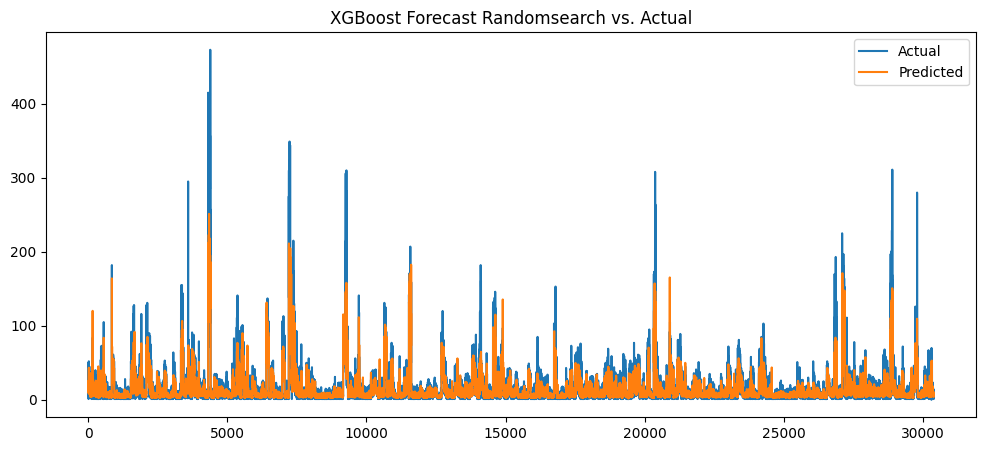

In [40]:
# Make predictions
# Vorhersage im Log-Raum
y_pred_log = final_model_rs.predict(X_test_prepared)

# Rücktransformation in Original-Skala
y_pred = np.expm1(y_pred_log)

metrics = forecast_metrics(y_test.values, y_pred)
for k, v in metrics.items():
    print(f"{k}: {v:,.2f}")

plt.figure(figsize=(12, 5))
plt.plot(y_test.values, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.title('XGBoost Forecast Randomsearch vs. Actual')
plt.show()

In [41]:
'''Unterschiede
MAE = absoluter Fehler → leicht interpretierbar (z. B. „im Schnitt um 5 Einheiten daneben“).
RMSE = stärker von Ausreißern beeinflusst.
SMAPE = symmetrische prozentuale Abweichung, skaliert zwischen 0–200 %.
wMAPE = gewichtete prozentuale Abweichung, gewichtet nach dem Umsatzvolumen → oft in Forecasting-Wettbewerben verwendet.
'''

# MAE & RMSE
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
#rmse = mean_squared_error(y_test, y_pred, squared=False)


# SMAPE
def smape(y_true, y_pred):
    return 100 * np.mean(
        2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred) + 1e-8)
    )

# wMAPE
def wmape(y_true, y_pred):
    return 100 * np.sum(np.abs(y_true - y_pred)) / np.sum(np.abs(y_true))

smape_val = smape(y_test, y_pred)
wmape_val = wmape(y_test, y_pred)

# Ausgabe
print("MAE = absoluter Fehler → leicht interpretierbar (z. B. „im Schnitt um 5 Einheiten daneben“).")
print(f"MAE   : {mae:.3f} units")
print("RMSE = stärker von Ausreißern beeinflusst.")
print(f"RMSE  : {rmse:.3f} units")
print("SMAPE = symmetrische prozentuale Abweichung, skaliert zwischen 0–200 %.")
print(f"SMAPE : {smape_val:.2f} %")
print("wMAPE = gewichtete prozentuale Abweichung, gewichtet nach dem Umsatzvolumen → oft in Forecasting-Wettbewerben verwendet.")
print(f"wMAPE : {wmape_val:.2f} %")


MAE = absoluter Fehler → leicht interpretierbar (z. B. „im Schnitt um 5 Einheiten daneben“).
MAE   : 6.664 units
RMSE = stärker von Ausreißern beeinflusst.
RMSE  : 14.284 units
SMAPE = symmetrische prozentuale Abweichung, skaliert zwischen 0–200 %.
SMAPE : 47.35 %
wMAPE = gewichtete prozentuale Abweichung, gewichtet nach dem Umsatzvolumen → oft in Forecasting-Wettbewerben verwendet.
wMAPE : 40.98 %


In [42]:
# Initializing the model
# xgb = XGBRegressor(objective='reg:squarederror', random_state=42, n_jobs=-1)

# Define the parameter grid, trying 3 values for each parameter
param_grid = {
    'eta': [0.01, 0.1, 0.3],
    'max_depth': [3, 5, 7],
    'subsample': [0.6, 0.7, 0.8, 1.0],
    'colsample_bytree': [0.7, 0.8, 1.0],
    'n_estimators': [100, 200, 300, 500]
}

# Time series split for cross-validation
tscv = TimeSeriesSplit(n_splits=5)

# Grid search with cross-validation
grid_search = GridSearchCV(estimator=xgboost_model,
                                               param_grid=param_grid,
                                               cv=tscv,
                                               scoring='neg_mean_squared_error')

# Fit the model and search for the best hyperparameters
grid_search.fit(X_train_prepared, y_train_log)

# Get best hyperparameters
best_params_gs = grid_search.best_params_
print("Best Parameters for XGBoost:", best_params_gs)

# lief 19m
# Best Parameters for XGBoost: {'colsample_bytree': 0.7, 'eta': 0.01, 'max_depth': 7, 'n_estimators': 500, 'subsample': 0.6}

Best Parameters for XGBoost: {'colsample_bytree': 0.7, 'eta': 0.01, 'max_depth': 7, 'n_estimators': 500, 'subsample': 0.6}


## MLFOW

In [43]:
# Sicherstellen, dass der Plots-Ordner existiert
os.makedirs("plots", exist_ok=True)

# GridSearch-Run in MLflow
with mlflow.start_run(run_name="XGB_GridSearch"):

    # Hyperparameter loggen (GridSearch-Ergebnis)
    mlflow.log_params(best_params_gs)
    mlflow.log_param("model_type", "XGBRegressor_GridSearch")

    # Finales Modell mit besten Parametern
    final_model_gs = XGBRegressor(
        objective='reg:squarederror',
        n_estimators=best_params_gs["n_estimators"],
        max_depth=best_params_gs["max_depth"],
        learning_rate=best_params_gs["eta"],
        subsample=best_params_gs["subsample"],
        colsample_bytree=best_params_gs["colsample_bytree"],
        random_state=42
    )

    # Training
    final_model_gs.fit(X_train_prepared, y_train_log)

    # Vorhersagen
    y_pred_log = final_model_gs.predict(X_test_prepared)
    y_pred = np.expm1(y_pred_log)  # Rücktransformation

    # Metriken berechnen
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)

    def smape(y_true, y_pred):
        return 100 * np.mean(
            2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred) + 1e-8)
        )

    def wmape(y_true, y_pred):
        return 100 * np.sum(np.abs(y_true - y_pred)) / np.sum(np.abs(y_true))

    smape_val = smape(y_test, y_pred)
    wmape_val = wmape(y_test, y_pred)

    # Metriken loggen
    mlflow.log_metric("MAE", mae)
    mlflow.log_metric("MSE", mse)
    mlflow.log_metric("RMSE", rmse)
    mlflow.log_metric("SMAPE", smape_val)
    mlflow.log_metric("wMAPE", wmape_val)

    # Plot erstellen
    plt.figure(figsize=(14, 7))
    plt.plot(y_test.index, y_test.values, label="Actual")
    plt.plot(y_test.index, y_pred, label="Predicted", color="red")
    plt.title("Actual vs Predicted Sales – GridSearch XGBoost")
    plt.legend()
    plt.tight_layout()

    # Plot speichern & loggen
    plot_file = os.path.join("plots", "forecast_XGB_GridSearch.png")
    plt.savefig(plot_file)
    plt.close()
    mlflow.log_artifact(plot_file)

    # Modell speichern
    mlflow.xgboost.log_model(final_model_gs, artifact_path="model")

print(f"GridSearch Run abgeschlossen – "
      f"MAE={mae:.2f}, RMSE={rmse:.2f}, SMAPE={smape_val:.2f}%, wMAPE={wmape_val:.2f}%")


2025/09/04 17:56:01 WARNING mlflow.models.model: `artifact_path` is deprecated. Please use `name` instead.
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/xgboost/sklearn.py:1028: UserWarning: [17:56:01] WARNING: /Users/runner/work/xgboost/xgboost/src/c_api/c_api.cc:1427: Saving model in the UBJSON format as default.  You can use file extension: `json`, `ubj` or `deprecated` to choose between formats.
  self.get_booster().save_model(fname)
2025/09/04 17:56:04 WARNING mlflow.models.model: Model logged without a signature and input example. Please set `input_example` parameter when logging the model to auto infer the model signature.


GridSearch Run abgeschlossen – MAE=6.79, RMSE=15.00, SMAPE=47.62%, wMAPE=41.75%


In [44]:
# Train your final XGBoost model using the best parameters you found, and evaluate its performance on the test set

# Define final model with best parameters
final_model_gs = XGBRegressor(
    objective='reg:squarederror',  # or use 'reg:linear' if you're on older versions
    enable_categorical=True,
    n_estimators=best_params_gs["n_estimators"],
    max_depth=best_params_gs["max_depth"],
    learning_rate=best_params_gs["eta"],
    subsample=best_params_gs["subsample"],
    colsample_bytree=best_params_gs["colsample_bytree"],
    random_state=42
)

In [45]:
# Train the model
final_model_gs.fit(X_train_prepared, y_train_log)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.7
,device,None
,early_stopping_rounds,None
,enable_categorical,True
,eval_metric,None


/var/folders/kc/4_58vml5169c4h_nkcgknsy80000gn/T/ipykernel_19721/90235439.py:15: RuntimeWarning: divide by zero encountered in divide
  'MAPE': np.mean(np.abs((y_true - y_pred) / y_true)) * 100


MAE: 6.79
RMSE: 15.00
MAPE: inf


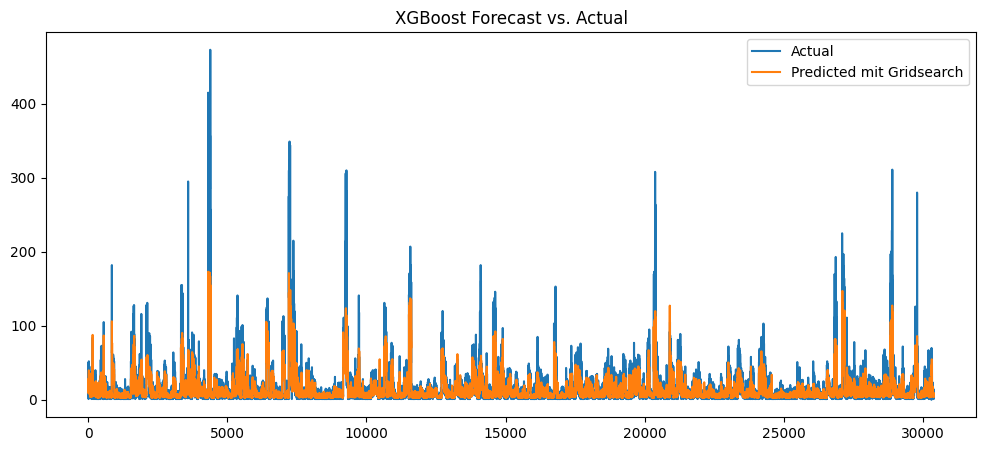

In [46]:
# Make predictions
# Vorhersage im Log-Raum
y_pred_log = final_model_gs.predict(X_test_prepared)

# Rücktransformation in Original-Skala
y_pred = np.expm1(y_pred_log)

metrics = forecast_metrics(y_test.values, y_pred)
for k, v in metrics.items():
    print(f"{k}: {v:,.2f}")

plt.figure(figsize=(12, 5))
plt.plot(y_test.values, label='Actual')
plt.plot(y_pred, label='Predicted mit Gridsearch')
plt.legend()
plt.title('XGBoost Forecast vs. Actual')
plt.show()

In [47]:
'''Unterschiede
MAE = absoluter Fehler → leicht interpretierbar (z. B. „im Schnitt um 5 Einheiten daneben“).
RMSE = stärker von Ausreißern beeinflusst.
SMAPE = symmetrische prozentuale Abweichung, skaliert zwischen 0–200 %.
wMAPE = gewichtete prozentuale Abweichung, gewichtet nach dem Umsatzvolumen → oft in Forecasting-Wettbewerben verwendet.
'''

# MAE & RMSE
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
#rmse = mean_squared_error(y_test, y_pred, squared=False)


# SMAPE
def smape(y_true, y_pred):
    return 100 * np.mean(
        2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred) + 1e-8)
    )

# wMAPE
def wmape(y_true, y_pred):
    return 100 * np.sum(np.abs(y_true - y_pred)) / np.sum(np.abs(y_true))

smape_val = smape(y_test, y_pred)
wmape_val = wmape(y_test, y_pred)

# Ausgabe
print("MAE = absoluter Fehler → leicht interpretierbar (z. B. „im Schnitt um 5 Einheiten daneben“).")
print(f"MAE   : {mae:.3f} units")
print("RMSE = stärker von Ausreißern beeinflusst.")
print(f"RMSE  : {rmse:.3f} units")
print("SMAPE = symmetrische prozentuale Abweichung, skaliert zwischen 0–200 %.")
print(f"SMAPE : {smape_val:.2f} %")
print("wMAPE = gewichtete prozentuale Abweichung, gewichtet nach dem Umsatzvolumen → oft in Forecasting-Wettbewerben verwendet.")
print(f"wMAPE : {wmape_val:.2f} %")

MAE = absoluter Fehler → leicht interpretierbar (z. B. „im Schnitt um 5 Einheiten daneben“).
MAE   : 6.789 units
RMSE = stärker von Ausreißern beeinflusst.
RMSE  : 14.997 units
SMAPE = symmetrische prozentuale Abweichung, skaliert zwischen 0–200 %.
SMAPE : 47.62 %
wMAPE = gewichtete prozentuale Abweichung, gewichtet nach dem Umsatzvolumen → oft in Forecasting-Wettbewerben verwendet.
wMAPE : 41.75 %
